# Roget's Thesaurus (Data and Embeddings)

> Konstantinos Mpouros <br>
> Github: https://github.com/konstantinosmpouros <br>
> Year: 2024 <br>

## 1. About the notebook
---

> The purpose of this notebook is to performe a part of the hole project (<b>Roget's Thesaurus in the 21st Century</b>) which is the data extraction and the embeddings creation.

> This Jupyter Notebook is dedicated to the extraction of textual data from [gutenberg's website](https://www.gutenberg.org/cache/epub/22/pg22-images.html) through web scraping techniques, followed by the generation of word embeddings for each word/phrase found within the scraped text. The notebook is divided into distinct sections, each focusing on a step of the process from data acquisition to preprocessing and finally, embedding generation. <br>

> The models that were used to create the embeddings are the **sentence transformer** and the **universal sentence encoder**. Both are transformer model that are dedicaded to better understand phrases and sentences. These two are selected in order to see the difference between the quality of the embeddings that they produce. Although the results might be better if instead of words, as input for the models, we used small sentences that descreabe the meaning of the word.  

## 2. Libraries
---

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np
import re

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Web Scraping
from bs4 import BeautifulSoup, NavigableString
import requests

# Pre-trained Embedding Models
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub

In [3]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

## 3. Data Extraction and Visualizations
---

### Data Extraction

> getting the html page in order to scrape it.

In [4]:
url = 'https://www.gutenberg.org/cache/epub/22/pg22-images.html'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/><style>
#pg-header div, #pg-footer div {
    all: initial;
    display: block;
    margin-top: 1em;
    margin-bottom: 1em;
    margin-left: 2em;
}
#pg-footer div.agate {
    font-size: 90%;
    margin-top: 0;
    margin-bottom: 0;
    text-align: center;
}
#pg-footer li {
    all: initial;
    display: block;
    margin-top: 1em;
    margin-bottom: 1em;
    text-indent: -0.6em;
}
#pg-footer div.secthead {
    font-size: 110%;
    font-weight: bold;
}
#pg-footer #project-gutenberg-license {
    font-size: 110%;
    margin-top: 0;
    margin-bottom: 0;
    text-align: center;
}
#pg-header-heading {
    all: inherit;
    text-align: center;
    font-size: 120%;
    font-weight:bold;
}
#pg-footer-heading {
    all: inherit;
    text-align: center;
    font-size: 120%;
    font-weight: normal;
    margin-top: 0;
    margin-bottom: 0;
}
#pg-header #pg-machine-header p {
    text-indent: -4em;
    margin-left: 4em;
    margin-to

> The content we want to scrape are all inside some div that there class was chapter, these divs contains in h2 tags that class and the division in some cases and then in h3 and h4 tags the section and subcategory. The words are in p tags and they needed a lot of cleaning to remove thing like '\r\n', '[containt]' and more.

In [5]:
body = soup.find_all('div', class_='chapter')

classes = ''
division = ''
section = ''
category = ''
roget_words = list()

for chapter in body:
    classes = str.strip(chapter.find('h2').text.replace('\r\n', ' '))
    chapter.find('h2').decompose()
    division = np.nan
    for tag in chapter:
        if tag.name == 'h2':
            division = str.strip(tag.text.replace('\r\n', ' '))
            division = re.sub(r'\[.*?\]', '', division)
        elif tag.name == 'h3':
            section = str.strip(tag.text.replace('\r\n', ' '))
            section = re.sub(r'\[.*?\]', '', section)
        elif tag.name == 'h4':
            category = tag.text.replace('\r\n', ' ')
            category = str.strip(re.sub(r"^\d+\.\s*", "", category))
            category = re.sub(r'\[.*?\]', '', category)
        elif tag.name == 'p':
            for content in tag.contents:
                # Check if the content is a NavigableString and not within tags
                if isinstance(content, NavigableString):                   
                    text = content.strip()
                    if len(text) > 0:
                        # Remove matched patterns from the string
                        pattern = r'(\xa0{5}|&c\.|V\.|v\.|#.*?\.—N\.|Phr\.|Adv\.|adv\.|Adj\.|adj\.|n\.|&c\. n\.|[\?!@$%^*+]|' \
                                  r'\d+\.|\d+|\(.*?\)|\[.*?\]|\{.*?\}|"|\d+[a-zA-Z]\.|#[^\s]*|-|\.—N\.|—N|[/\\|<>:]|adj\[[^\]]*\])'
                        cleaned_text = re.sub(pattern, '', text).replace('-|\r\n|\r|\n', ' ')

                        # Split the text and append each word with each categorization
                        for word in re.split('[,;.]', cleaned_text):
                            if len(str.strip(word)) > 1:
                                final_word = re.sub(r'\s+', ' ', str.strip(word))
                                roget_words.append([classes, division, section, category, final_word])

roget_words = pd.DataFrame(roget_words, columns=['Class', 'Division', 'Primary_Section', 'Sub_Section', 'Word'])

In [7]:
print(roget_words.shape)
roget_words.head()

(97081, 5)


,Class,Division,Primary_Section,Sub_Section,Word
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",existence
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",being
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",entity
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",subsistence
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",reality


> Nan check

In [8]:
roget_words[pd.notna(roget_words['Division']) & pd.isna(roget_words['Sub_Section'])]

,Class,Division,Primary_Section,Sub_Section,Word


> its is appropriate to have nans in the division cause only in 2 clases we have division and then section and sub section.

In [9]:
roget_words.isna().sum()

Class                  0
Division           57995
Primary_Section        0
Sub_Section            0
Word                   0
dtype: int64

In [10]:
roget_words.Class.unique()

array(['CLASS I WORDS EXPRESSING ABSTRACT RELATIONS',
       'CLASS II WORDS RELATING TO SPACE',
       'CLASS III WORDS RELATING TO MATTER',
       'CLASS IV WORDS RELATING TO THE INTELLECTUAL FACULTIES',
       'CLASS V WORDS RELATING TO THE VOLUNTARY POWERS',
       'CLASS VI WORDS RELATING TO THE SENTIMENT AND MORAL POWERS'],
      dtype=object)

In [11]:
roget_words.Division.unique()

array([nan, 'DIVISION (I) FORMATION OF IDEAS',
       'DIVISION (II) COMMUNICATION OF IDEAS',
       'DIVISION (I) INDIVIDUAL VOLITION',
       'DIVISION (II) INTERSOCIAL VOLITION'], dtype=object)

In [12]:
roget_words.Primary_Section.nunique()

39

In [13]:
roget_words.Primary_Section.unique()

array(['SECTION I. EXISTENCE', 'SECTION II. RELATION',
       'SECTION III. QUANTITY', 'SECTION IV. ORDER', 'SECTION V. NUMBER',
       'SECTION VI. TIME', 'SECTION VII. CHANGE',
       'SECTION VIII. CAUSATION', 'SECTION I. SPACE IN GENERAL',
       'SECTION II. DIMENSIONS', 'SECTION III. FORM',
       'SECTION IV. MOTION', 'SECTION I. MATTER IN GENERAL',
       'SECTION II. INORGANIC MATTER', 'SECTION III. ORGANIC MATTER',
       'SECTION I. OPERATIONS OF INTELLECT IN GENERAL',
       'SECTION II. PRECURSORY CONDITIONS AND OPERATIONS',
       'SECTION III. MATERIALS FOR REASONING',
       'SECTION IV. REASONING PROCESSES',
       'SECTION V. RESULTS OF REASONING',
       'SECTION VI. EXTENSION OF THOUGHT',
       'SECTION VII. CREATIVE THOUGHT',
       'SECTION I. NATURE OF IDEAS COMMUNICATED',
       'SECTION II. MODES OF COMMUNICATION',
       'SECTION III. MEANS OF COMMUNICATING IDEAS',
       'SECTION I. VOLITION IN GENERAL',
       'SECTION II. PROSPECTIVE VOLITION',
       'SEC

In [14]:
roget_words.Sub_Section.unique()

array(['BEING, IN THE ABSTRACT', 'BEING, IN THE CONCRETE',
       'FORMAL EXISTENCE', 'MODAL EXISTENCE', 'ABSOLUTE RELATION',
       'CONTINUOUS RELATION', 'PARTIAL RELATION', 'GENERAL RELATION',
       'SIMPLE QUANTITY', 'COMPARATIVE QUANTITY',
       'QUANTITY BY COMPARISON WITH A STANDARD',
       'QUANTITY BY COMPARISON WITH A SIMILAR OBJECT',
       'CHANGES IN QUANTITY', 'CONJUNCTIVE QUANTITY', 'CONCRETE QUANTITY',
       'ORDER IN GENERAL', 'CONSECUTIVE ORDER', 'COLLECTIVE ORDER',
       'DISTRIBUTIVE ORDER', 'ORDER AS REGARDS CATEGORIES',
       'NUMBER, IN THE ABSTRACT', 'DETERMINATE NUMBER',
       'INDETERMINATE NUMBER', 'ABSOLUTE TIME', 'RELATIVE TIME',
       'RECURRENT TIME', 'SIMPLE CHANGE', 'COMPLEX CHANGE',
       'CONSTANCY OF SEQUENCE IN EVENTS',
       'CONNECTION BETWEEN CAUSE AND EFFECT', 'POWER IN OPERATION',
       'INDIRECT POWER', 'COMBINATIONS OF CAUSES', 'ABSTRACT SPACE',
       'RELATIVE SPACE', 'EXISTENCE IN SPACE', 'GENERAL DIMENSIONS',
       'LINEAR DIM

> Creating a column called Section that have the appropriate second tier division of the classification that roget did even if these is called division or section. This column will be used are the second tier clustering and prediction.

In [15]:
roget_words['Section'] = np.where(pd.isna(roget_words['Division']), roget_words['Primary_Section'], roget_words['Division'])
roget_words[roget_words['Division'].isna() == False].tail()

,Class,Division,Primary_Section,Sub_Section,Word,Section
77084,CLASS V WORDS RELATING TO THE VOLUNTARY POWERS,DIVISION (II) INTERSOCIAL VOLITION,SECTION IV. POSSESSIVE RELATIONS,Monetary Relations,rapacious,DIVISION (II) INTERSOCIAL VOLITION
77085,CLASS V WORDS RELATING TO THE VOLUNTARY POWERS,DIVISION (II) INTERSOCIAL VOLITION,SECTION IV. POSSESSIVE RELATIONS,Monetary Relations,with a sparing hand,DIVISION (II) INTERSOCIAL VOLITION
77086,CLASS V WORDS RELATING TO THE VOLUNTARY POWERS,DIVISION (II) INTERSOCIAL VOLITION,SECTION IV. POSSESSIVE RELATIONS,Monetary Relations,desunt inopioe multa avaritiae omnia,DIVISION (II) INTERSOCIAL VOLITION
77087,CLASS V WORDS RELATING TO THE VOLUNTARY POWERS,DIVISION (II) INTERSOCIAL VOLITION,SECTION IV. POSSESSIVE RELATIONS,Monetary Relations,hoards after hoards his rising raptures fill,DIVISION (II) INTERSOCIAL VOLITION
77088,CLASS V WORDS RELATING TO THE VOLUNTARY POWERS,DIVISION (II) INTERSOCIAL VOLITION,SECTION IV. POSSESSIVE RELATIONS,Monetary Relations,the unsunn'd heaps of miser's treasures,DIVISION (II) INTERSOCIAL VOLITION


In [16]:
roget_words[roget_words['Division'].isna() == True].tail()

,Class,Division,Primary_Section,Sub_Section,Word,Section
97076,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,monastic,SECTION V. RELIGIOUS AFFECTIONS
97077,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,monasterial,SECTION V. RELIGIOUS AFFECTIONS
97078,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,conventual,SECTION V. RELIGIOUS AFFECTIONS
97079,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,ne vile fano,SECTION V. RELIGIOUS AFFECTIONS
97080,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,there's nothing ill can dwell in such a temple,SECTION V. RELIGIOUS AFFECTIONS


In [17]:
roget_words.Section.nunique()

24

In [18]:
roget_words.Section.unique()

array(['SECTION I. EXISTENCE', 'SECTION II. RELATION',
       'SECTION III. QUANTITY', 'SECTION IV. ORDER', 'SECTION V. NUMBER',
       'SECTION VI. TIME', 'SECTION VII. CHANGE',
       'SECTION VIII. CAUSATION', 'SECTION I. SPACE IN GENERAL',
       'SECTION II. DIMENSIONS', 'SECTION III. FORM',
       'SECTION IV. MOTION', 'SECTION I. MATTER IN GENERAL',
       'SECTION II. INORGANIC MATTER', 'SECTION III. ORGANIC MATTER',
       'DIVISION (I) FORMATION OF IDEAS',
       'DIVISION (II) COMMUNICATION OF IDEAS',
       'DIVISION (I) INDIVIDUAL VOLITION',
       'DIVISION (II) INTERSOCIAL VOLITION',
       'SECTION I. AFFECTIONS IN GENERAL',
       'SECTION II. PERSONAL AFFECTIONS',
       'SECTION III. SYMPATHETIC AFFECTIONS',
       'SECTION IV. MORAL  AFFECTIONS', 'SECTION V. RELIGIOUS AFFECTIONS'],
      dtype=object)

> Duplicate check. We search for duplicated words that exist in the same class, section and sub section.
> We can see that these word are a lot!

In [20]:
roget_words[roget_words.duplicated(subset=['Class', 'Primary_Section', 'Sub_Section', 'Word'], keep=False)].sort_values('Word')

,Class,Division,Primary_Section,Sub_Section,Word,Section
95326,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,SUPERHUMAN BEINGS AND REGIONS,Abaddon,SECTION V. RELIGIOUS AFFECTIONS
95047,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,SUPERHUMAN BEINGS AND REGIONS,Abaddon,SECTION V. RELIGIOUS AFFECTIONS
95025,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,SUPERHUMAN BEINGS AND REGIONS,Ahriman,SECTION V. RELIGIOUS AFFECTIONS
95179,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,SUPERHUMAN BEINGS AND REGIONS,Ahriman,SECTION V. RELIGIOUS AFFECTIONS
51148,CLASS IV WORDS RELATING TO THE INTELLECTUAL FA...,DIVISION (II) COMMUNICATION OF IDEAS,SECTION III. MEANS OF COMMUNICATING IDEAS,Conventional Means,Alexandrine,DIVISION (II) COMMUNICATION OF IDEAS
...,...,...,...,...,...,...
20733,CLASS II WORDS RELATING TO SPACE,NaN,SECTION III. FORM,Special Form,zigzag,SECTION III. FORM
31680,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,VITALITY,zoology,SECTION III. ORGANIC MATTER
30542,CLASS III WORDS RELATING TO MATTER,NaN,SECTION III. ORGANIC MATTER,VITALITY,zoology,SECTION III. ORGANIC MATTER
59385,CLASS V WORDS RELATING TO THE VOLUNTARY POWERS,DIVISION (I) INDIVIDUAL VOLITION,SECTION II. PROSPECTIVE VOLITION,Subservience to Ends,zymotic,DIVISION (I) INDIVIDUAL VOLITION


In [21]:
roget_words.drop_duplicates(subset=['Class', 'Primary_Section', 'Sub_Section', 'Word'], keep='last').reset_index(drop=True)

,Class,Division,Primary_Section,Sub_Section,Word,Section
0,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",existence,SECTION I. EXISTENCE
1,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",being,SECTION I. EXISTENCE
2,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",entity,SECTION I. EXISTENCE
3,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",subsistence,SECTION I. EXISTENCE
4,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",reality,SECTION I. EXISTENCE
...,...,...,...,...,...,...
88348,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,monastic,SECTION V. RELIGIOUS AFFECTIONS
88349,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,monasterial,SECTION V. RELIGIOUS AFFECTIONS
88350,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,conventual,SECTION V. RELIGIOUS AFFECTIONS
88351,CLASS VI WORDS RELATING TO THE SENTIMENT AND M...,NaN,SECTION V. RELIGIOUS AFFECTIONS,RELIGIOUS INSTITUTIONS,ne vile fano,SECTION V. RELIGIOUS AFFECTIONS


In [22]:
roget_words = roget_words.drop_duplicates(subset=['Class', 'Primary_Section', 'Sub_Section', 'Word'], keep='last').reset_index(drop=True)

* Word with extremly small length

In [51]:
roget_words[roget_words['Word'].str.len().isin([2])].Word[:30]

25       be
124      go
477      do
552      if
1192     so
1558     do
2045     in
2321     so
4384     as
4430     in
6066     ki
6138     ru
8807     by
9142     in
9351     St
10249    St
10922    of
11431    to
12409    do
13023    in
13031    by
13042    go
14055    in
14251    be
14367    in
14763    of
16092    AU
16096    nm
16101    mm
16103    cm
Name: Word, dtype: object

In [52]:
roget_words.loc[[9351, 10249]]

,Class,Division,Primary_Section,Sub_Section,Word,Section
9351,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION VI. TIME,RELATIVE TIME,St,SECTION VI. TIME
10249,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION VI. TIME,RECURRENT TIME,St,SECTION VI. TIME


In [49]:
roget_words[roget_words['Word'].str.len().isin([3])].Word[:30]

92      nil
119     out
126     die
153     vai
222     nil
254     air
303     ego
316     sap
440     lot
454     set
455     fit
535     the
596     tie
780     sib
896     ilk
904     one
1257    new
1313    ape
1317    act
1348    sic
1429    sca
1485    die
1574    fit
1615    apt
1618    pat
1695    jar
1773    sum
1790    lot
1794    fix
1801    any
Name: Word, dtype: object

In [50]:
roget_words.loc[[92, 222]]

,Class,Division,Primary_Section,Sub_Section,Word,Section
92,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE ABSTRACT",nil,SECTION I. EXISTENCE
222,CLASS I WORDS EXPRESSING ABSTRACT RELATIONS,NaN,SECTION I. EXISTENCE,"BEING, IN THE CONCRETE",nil,SECTION I. EXISTENCE


> Save the words and the classification in a csv to access it in the reset notebooks

In [23]:
roget_words.to_csv("Dataset/Roget's_Words.csv", index=False)

### Data Visualizations

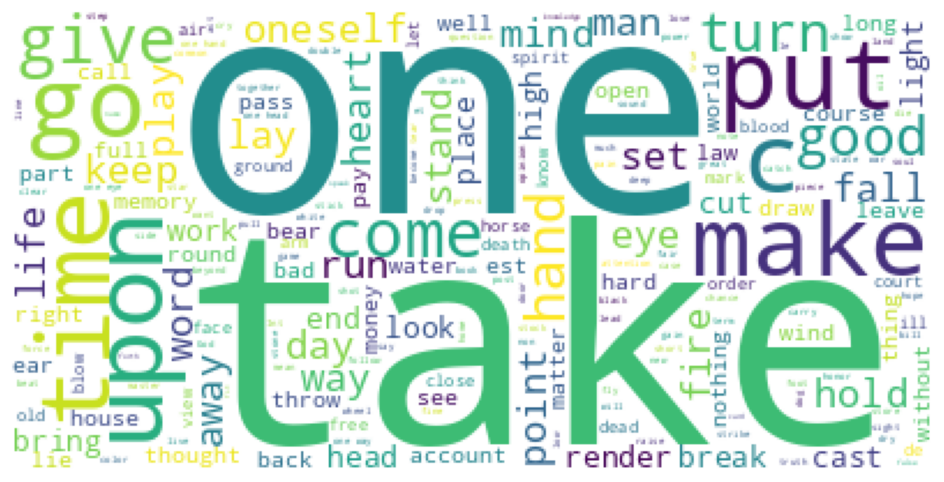

In [24]:
plt.figure(figsize=(15, 6))

all_words =  ' '.join(word for word in roget_words['Word'])
wordcloud = WordCloud(background_color='white',
                              repeat=True,
                              contour_color='black',
                              contour_width=.5,
                              min_font_size=2,
                             )

wordcloud.generate(all_words)
plt.imshow(wordcloud)
plt.axis('off')

plt.show()

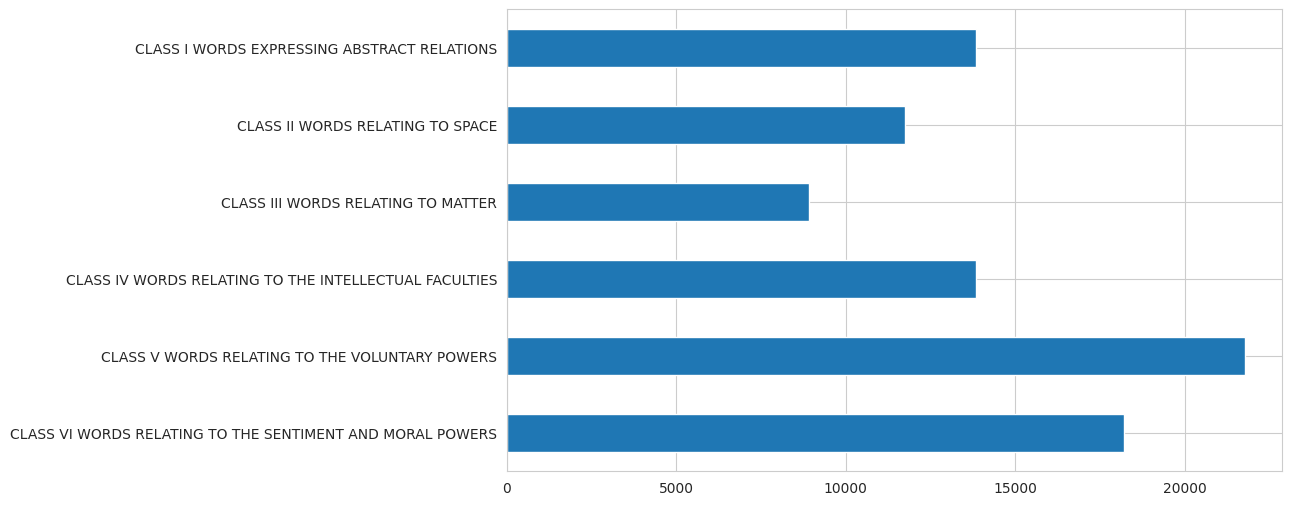

In [37]:
plt.figure(figsize=(10, 6))
roget_words['Class'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.ylabel(None)

plt.show()

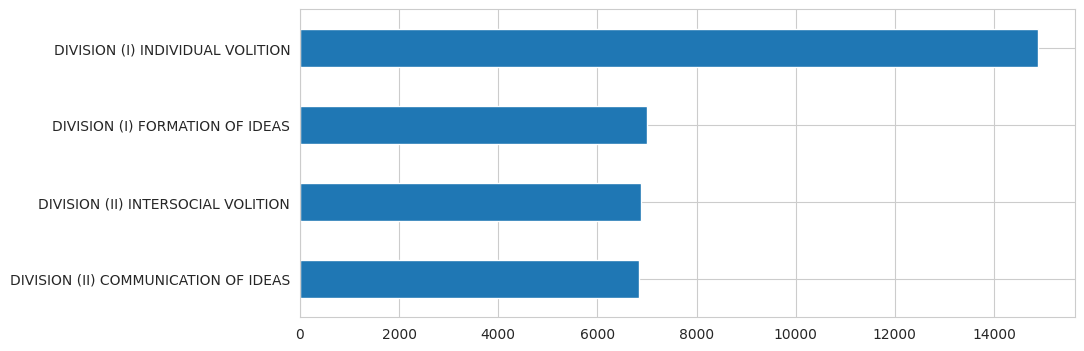

In [36]:
plt.figure(figsize=(10, 4))
roget_words['Division'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.ylabel(None)

plt.show()

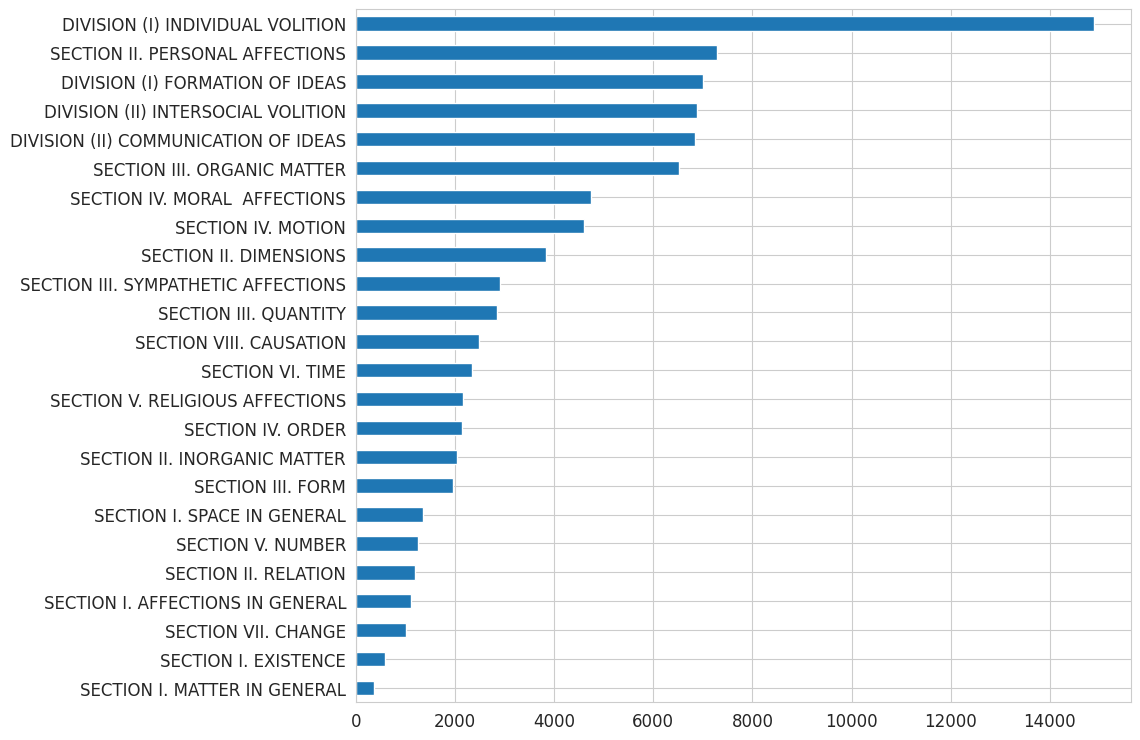

In [38]:
plt.figure(figsize=(10, 9))
roget_words['Section'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.ylabel(None)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

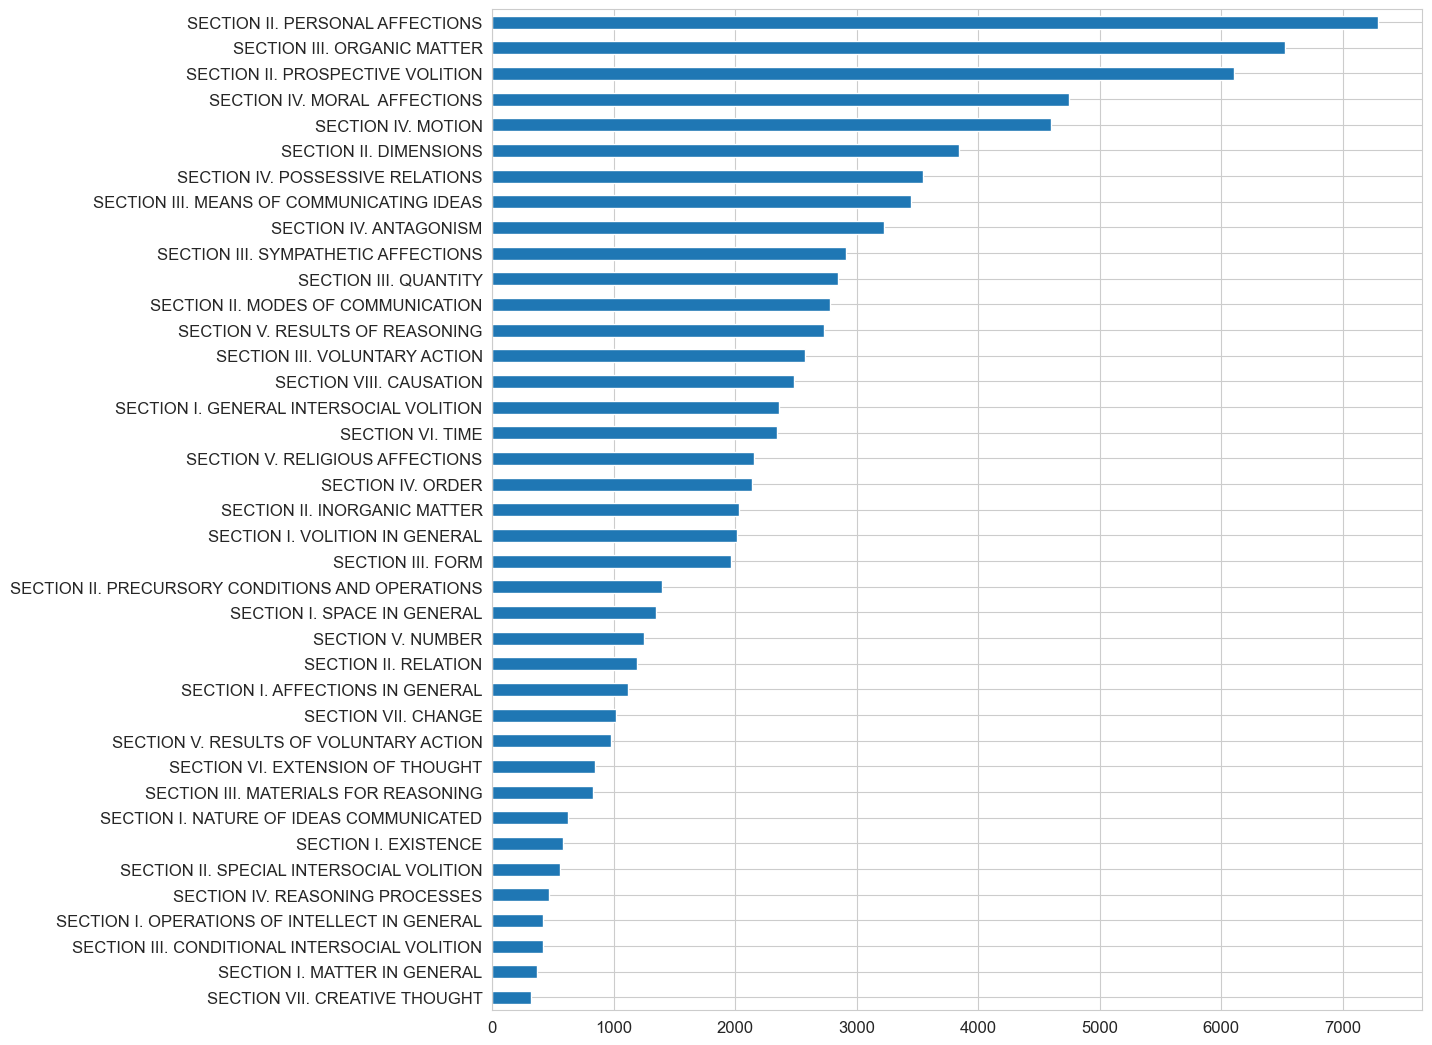

In [25]:
plt.figure(figsize=(12, 13))
roget_words['Primary_Section'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.ylabel(None)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

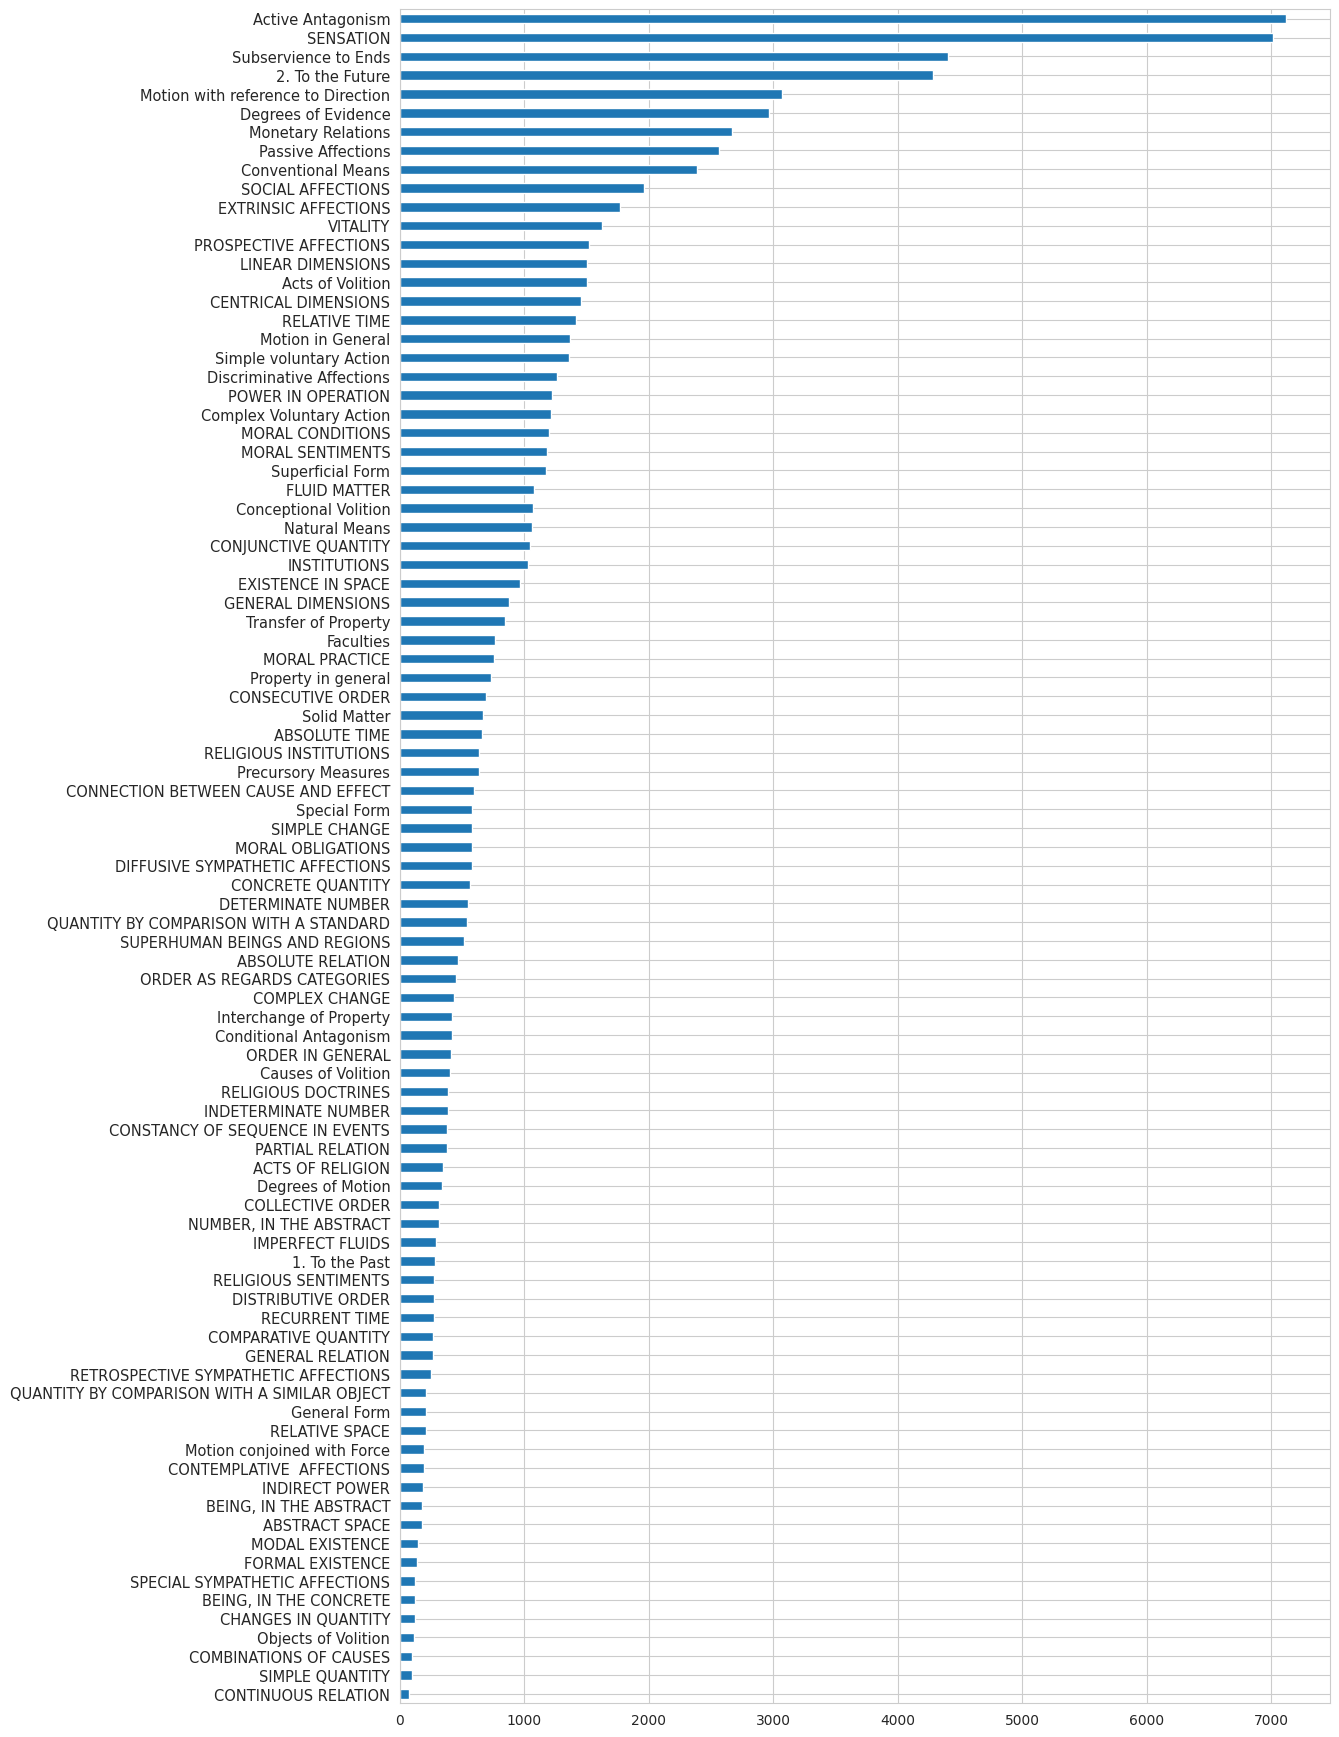

In [39]:
plt.figure(figsize=(12, 22))
roget_words['Sub_Section'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.ylabel(None)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10.5)

plt.show()

## 4. Roget's Words Embeddings
---

### Sentence Transformers

In [27]:
# Load the pre-trained model
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [28]:
# Generate embeddings
sentence_tranformer_embeddings = sentence_transformer.encode(roget_words['Word'])

In [29]:
# Embeddings number match the number of the words so nothing was left behind
len(sentence_tranformer_embeddings), len(roget_words['Word'])

(88353, 88353)

> the embeddings that we generated have 384 dimensions

In [30]:
len(sentence_tranformer_embeddings[0]), sentence_tranformer_embeddings[0]

(384,
 array([-6.88087717e-02,  1.55753701e-03, -6.29944056e-02,  3.74078713e-02,
        -4.55042757e-02,  5.26713878e-02,  7.77645707e-02, -3.93479429e-02,
         5.62467128e-02, -1.42512592e-02,  8.08920041e-02, -2.26018541e-02,
         4.83769402e-02,  4.58013639e-03, -2.98777682e-04, -1.23144761e-02,
         2.97384970e-02, -1.40542895e-01, -5.67162558e-02, -3.01478244e-02,
        -1.84678361e-02, -1.94176584e-02, -5.83643205e-02,  5.72983846e-02,
        -5.80368116e-02,  6.67893216e-02,  1.90744158e-02,  3.61798517e-03,
         5.28540350e-02, -6.97542876e-02,  4.56807762e-03,  1.30921211e-02,
         2.33698767e-02, -2.66002305e-02,  8.31490979e-02,  6.35661706e-02,
         4.94408123e-02, -3.30641605e-02, -1.83385555e-02, -6.20432310e-02,
        -7.77266249e-02, -5.32190725e-02,  2.67560910e-02, -5.71331941e-02,
         5.26195951e-03,  3.00009712e-03,  4.67874445e-02,  4.86986190e-02,
         4.02051434e-02, -4.59004492e-02, -1.34900734e-01,  1.48217240e-03,
      

> Save the embeddings of the sentence transformer in a json that we can access it again from the other notebooks

In [31]:
list_of_arrays = [row.reshape(-1) for row in sentence_tranformer_embeddings]
sentence_tranformer_embeddings = pd.DataFrame({'Embeddings': list_of_arrays})
sentence_tranformer_embeddings

,Embeddings
0,"[-0.06880877, 0.001557537, -0.062994406, 0.037..."
1,"[0.0024004122, 0.020551782, 0.05093384, 0.0796..."
2,"[-0.009778404, -3.9502018e-05, -0.012824397, 0..."
3,"[-0.012498525, 0.08108827, -0.050416943, 0.071..."
4,"[-0.013266126, 0.0121876495, -0.06195835, 0.05..."
...,...
88348,"[0.025549076, 0.024066204, -0.076214105, -0.01..."
88349,"[0.01691342, -0.064730465, -0.009402724, -0.01..."
88350,"[0.073002696, -0.024290988, -0.07910911, 0.019..."
88351,"[0.012583305, 0.033830814, -0.012103504, -0.04..."


In [32]:
sentence_tranformer_embeddings.reset_index(drop=True).to_json('Embeddings/sentence_tranformer_embeddings.json')

### Universal Sentence Encoder

In [33]:
# Loading the Universal Sentence Encoder model
module_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"
model = hub.load(module_url)

In [34]:
# Generate embeddings
use_embeddings = model(roget_words['Word'])

> We have the same number of embeddings as the words and each embeddings have 512 dimensions

In [35]:
len(use_embeddings), len(use_embeddings[0])

(88353, 512)

> Save the embeddings

In [36]:
list_of_arrays = [row.numpy().reshape(-1) for row in use_embeddings]
use_embeddings = pd.DataFrame({'Embeddings': list_of_arrays})
use_embeddings

,Embeddings
0,"[-0.03963796, -0.04299992, -0.027402975, 0.029..."
1,"[-0.038279638, -0.057040974, 0.056322448, 0.03..."
2,"[-0.040613506, 0.013880508, -0.027027112, 0.00..."
3,"[-0.017703883, -0.079342976, -0.018696247, 0.0..."
4,"[-0.04043988, 0.007750398, -0.04859837, 0.0170..."
...,...
88348,"[0.049187656, -0.045370482, 0.039664596, -0.06..."
88349,"[-0.03531103, -0.029534943, 0.011603884, 0.045..."
88350,"[0.011396672, -0.03598554, 0.031265326, 0.0020..."
88351,"[-0.05716852, 0.027027575, -0.050583873, -0.03..."


In [37]:
use_embeddings.reset_index(drop=True).to_json('Embeddings/universal_sentence_encoder_embeddings.json')